In [92]:
import os
os.environ["OMP_NUM_THREADS"]='1'
import osmnx as ox
import networkx as nx
from datetime import datetime

import pandas as pd
import geopandas as gpd

from pyproj import Transformer 
import numpy as np
import scipy
from descartes import PolygonPatch

import matplotlib.pyplot as plt
from matplotlib import *
from matplotlib.patches import *
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors

import contextily as cx #Copyright (c) 2016, Dani Arribas-Bel. All rights reserved.

import math
import itertools
from shapely.geometry import MultiPolygon, Polygon, Point, LineString
from shapely.ops import nearest_points
from IPython.display import Image, IFrame

from sklearn import cluster
from sklearn.cluster import KMeans


import pandapower as pp
import pandapower.timeseries as ts
import pandapower.control as control
from pandapower.plotting import simple_plot, simple_plotly, pf_res_plotly 


# 1. Daten sammeln und aufbereiten

In [2]:
#Polygon als GeoDataFrame
polygon = gpd.read_file(r".\Layer\Industriegebiet_Eingrenzung.shp")
#Polygon als Polygon-Objekt
new_poly = polygon["geometry"].iloc[0]

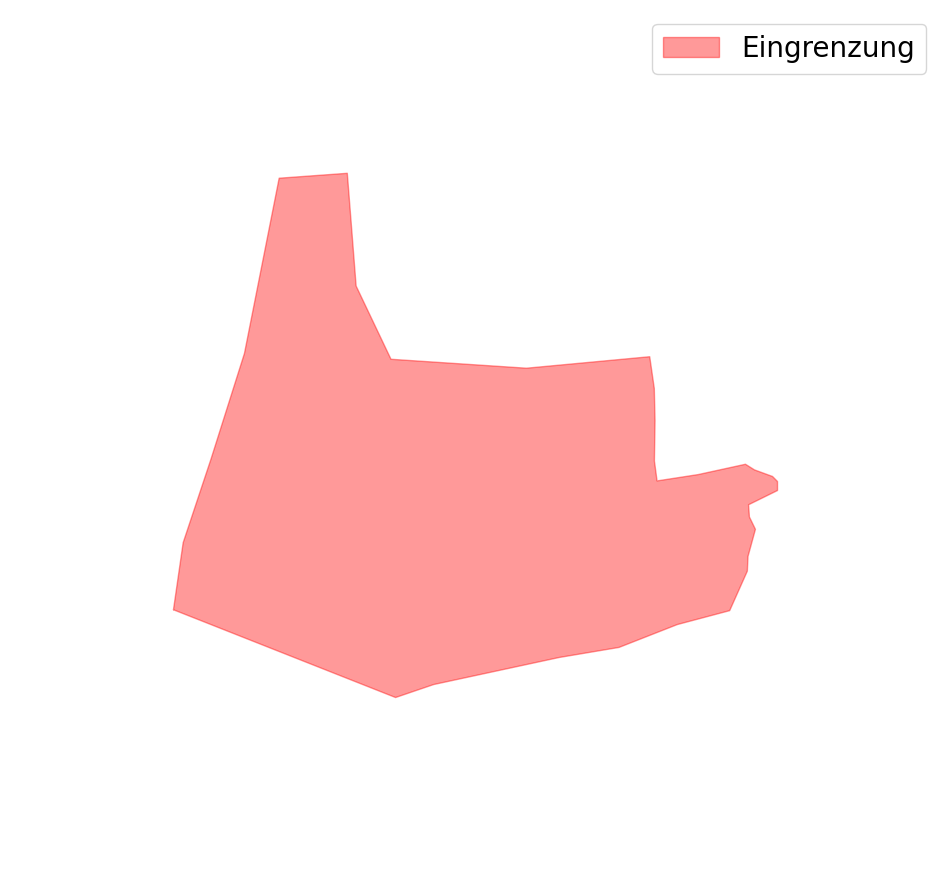

In [3]:
# PLOT DER EINGRENZUNG

#Konvertierung in metrisches System
poly_draw = polygon.to_crs(epsg=25832)
# geometrische Form des Polygons
polygon_geometry = poly_draw.unary_union
#Min & Max x,y werte des Polygons
min_x, min_y, max_x, max_y = polygon_geometry.bounds

zoom_factor = 500
#neue Eingrenzungen des Plots
new_min_x = min_x-zoom_factor
new_max_x = max_x+zoom_factor
new_min_y = min_y-zoom_factor
new_max_y = max_y+zoom_factor

fig, ax=plt.subplots(1, figsize=(12,15))
poly_draw.plot(ax=ax, edgecolor='red', facecolor='red', alpha=0.4)

ax.set_axis_off()

ax.set_xlim(new_min_x, new_max_x)
ax.set_ylim(new_min_y, new_max_y)

legend_elements= [Patch(edgecolor='red', facecolor='red', alpha =0.4, label='Eingrenzung')]
ax.legend(handles=legend_elements, loc='upper right', fontsize=20)

#cx.add_basemap(ax=ax, crs=poly_draw.crs)


#plt.savefig(r'H:\Studium\7_Semester\BA\BA Schreiben\Bilder\eingrenzung_ind.svg', format='svg', bbox_inches='tight')

plt.show()

# 1.1 Gebäude erfassen und Datensatz Filtern

In [4]:
#alle Gebäude innerhalb des Polygons erfassen
buildings = ox.features.features_from_polygon(new_poly, tags={"building":True})

#Auf wichtigste Columns beschränken:
buildings = buildings.filter(['geometry', 'nodes', 'building','building:levels','power', 'ways', axis=='columns'])

#Alle NaN Stockwerkwerte mit 2,475 ersetzen:
buildings[['building:levels']] = buildings[['building:levels']].fillna(float(2.475))

In [5]:
#Gebäudezentren bestimmen
#buildings = buildings.to_crs(epsg=4326)
centroid_calc = buildings.to_crs(epsg=25832)#4326
centroids = centroid_calc.centroid
lons = list(centroids.x)
lats = list(centroids.y)

building_coords = [[lons[i],lats[i]] for i in range(len(lons))]
buildings = buildings.to_crs(epsg=25832)
#print(building_coords)

In [6]:
#Straßengraph mit oder ohne custom_filter erstellen
cf = '["highway"~"unclassified|residential|secondary|secondary_link|tertiary|tertiary_link|turning_circle|turning_loop"]'
streets_graph_poly = ox.graph_from_polygon(new_poly, simplify=False, retain_all=True, truncate_by_edge=False)
streets_graph_poly = ox.project_graph(streets_graph_poly, to_crs=25832)
#fig, ax = ox.plot_graph(streets_graph_poly, node_size=5, bgcolor='w', node_color='k')

In [7]:
nodes= ox.graph_to_gdfs(streets_graph_poly, nodes=True, edges=False)
edges= ox.graph_to_gdfs(streets_graph_poly, edges=True, nodes=False)
#nodes.plot()
#edges.plot()


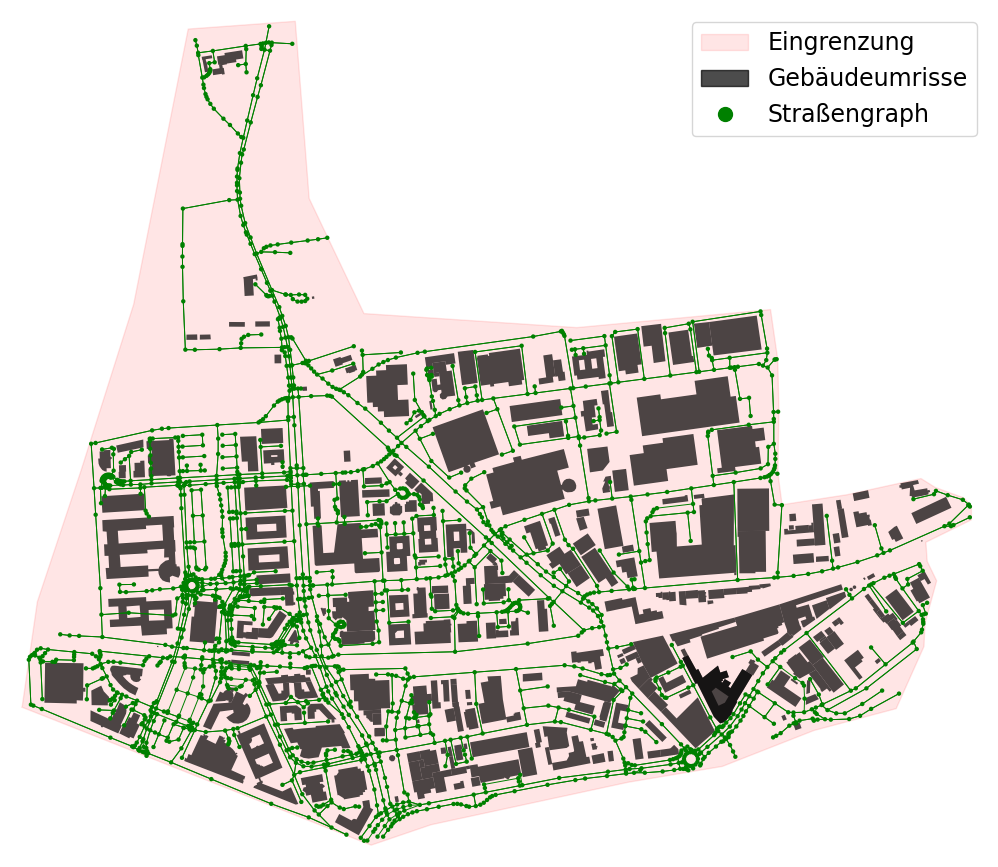

In [8]:
#PLOT DER GEBÄUDE UND STRAßENGRAPHEN

fig, ax=plt.subplots(1, figsize=(13,11))
ax.set_axis_off()
ax.set_aspect('equal')
poly_draw.plot(ax=ax, edgecolor='red', facecolor='red', alpha=0.1)
#Gebäude
buildings.plot(ax=ax, alpha=0.7, color='black')
#Legende
legend_elements = [
    Patch(color='red', alpha =0.1, label='Eingrenzung'),
    Patch(color='black', alpha =0.7, label='Gebäudeumrisse'),
    Line2D([0], [0], marker='o', color='green', markersize=10, label='Straßengraph', linestyle='None')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=17)
#Straßengraph

ox.plot_graph(streets_graph_poly, ax=ax, node_size=10, edge_color="green", node_color="green", edge_linewidth=0.7, save=False, filepath=r'H:\Studium\7_Semester\BA\BA Schreiben\Bilder\buildings_and_g.svg')
plt.show()

# Flächeninhalt

In [9]:
#Flächeninhalt der Gebäude
buildings_poly = buildings['geometry']
#Transformation der Coordinaten in x,y Werten zur Flächenberechnung
buildings_poly_m = buildings_poly.to_crs(25832)
#Speichern der Flächen in Übergangsarray
buildings_area=[]
for i in range(len(buildings_poly_m)):
    buildings_area.append(buildings_poly_m.iloc[i].area)
    #print(buildings_area[i])
    
#Hinzufügen der berechneten Flächen zum GeoDataFrame (buildings)
buildings.insert(loc=0, column='flaeche', value=buildings_area)
#buildings

# Gebäudeeigenschaften mit ALKIS zuweisen

In [10]:
#ALKIS Daten importieren
polygon_alkis = gpd.read_file(r".\Daten\Weilimdorf")
#Polygon als Polygon-Objekt
new_poly_alkis = polygon_alkis["geometry"].iloc[0]
#Konvertierung in metrisches System
alkis = polygon_alkis.to_crs(epsg=25832)


In [11]:
def assign_function_to_building(buildings_gdf,alkis_gdf):
    #ordnet Gebäuden das Passende Alkis Gebäude bzw. dessen Funktion zu 

    # Initialisiere die neue Spalte 'function' mit None
    buildings_gdf['function'] = None
    buildings_gdf['adr'] = None
    # Iteriere durch jedes Gebäude
    for idx, building in buildings_gdf.iterrows():
        
        # Finde alle ALKIS Polygone, die sich mit dem aktuellen Gebäude überschneiden
        overlapping_alkis = alkis_gdf[alkis_gdf.intersects(building.geometry)]
        
        if not overlapping_alkis.empty:
            # Falls es Überschneidungen gibt, nehme den Wert der Spalte 'funktion' des ersten überschneidenden Polygons
            buildings_gdf.at[idx, 'function'] = overlapping_alkis.iloc[0]['funktion']
            buildings_gdf.at[idx, 'adr'] = overlapping_alkis.iloc[0]['lagebeztxt']

    return buildings_gdf

In [12]:
updated_buildings = assign_function_to_building(buildings,alkis)

In [13]:
def assign_nearest_function(buildings_gdf):
    #Gebäuden ohne Typ den Typ des nächstgelegenen Gebäudes zuweisen
    buildings_with_function = buildings_gdf[buildings_gdf['function'].notnull()]
    buildings_without_function = buildings_gdf[buildings_gdf['function'].isnull()]

    for idx, building in buildings_without_function.iterrows():
        # Berechne die Entfernung zu allen Gebäuden mit Funktion und finde die nächste
        nearest_building = buildings_with_function.distance(building.geometry).idxmin()
        
        # Weise die Funktion des nächsten Gebäudes zu
        nearest_function = buildings_with_function.loc[nearest_building, 'function']
        buildings_gdf.at[idx, 'function'] = nearest_function
    
    return buildings_gdf

In [14]:
def count_building_functions(buildings_gdf):
    # Zähle die Häufigkeit der verschiedenen Gebäudetypen
    function_counts = buildings_gdf['function'].value_counts().reset_index()
    function_counts.columns = ['function', 'count']
    return function_counts

In [15]:
all_buildings_with_function = assign_nearest_function(updated_buildings)
function_counts = count_building_functions(all_buildings_with_function)

# Tabelle ausgeben
print(function_counts)

                      function  count
0              Betriebsgebäude     70
1                  Bürogebäude     52
2   Gebäude für Vorratshaltung     49
3                   Tiefgarage     17
4             Geschäftsgebäude     14
5        Wohn- und Bürogebäude     11
6                       Fabrik     10
7                     Wohnhaus     10
8                    Werkstatt      9
9                       Garage      9
10   Wohn- und Betriebsgebäude      9
11                    Umformer      5
12                    Parkhaus      5
13                    Schuppen      4
14          Wirtschaftsgebäude      3
15  Wohn- und Geschäftsgebäude      2
16                 Überdachung      2
17       Hotel, Motel, Pension      2
18   Allgemein bildende Schule      2
19                     Scheune      1
20     Gebäude für Sportzwecke      1
21                    Wohnheim      1
22                  Tankstelle      1
23             Empfangsgebäude      1
24      Gaststätte, Restaurant      1


In [16]:
def plot_building_functions(buildings_gdf,selected_function):
    # Einzigartige Gebäudetypen und ihre Farben definieren
    unique_functions = buildings_gdf[selected_function].unique()
    num_colors = len(unique_functions)
    colors = plt.cm.hsv(np.linspace(0, 1, num_colors))
    color_dict = dict(zip(unique_functions, colors))

    # Plot initialisieren
    fig, ax = plt.subplots(figsize=(12, 12))

    # Durch die Gebäudetypen iterieren und jeden Typ plotten
    for function, color in color_dict.items():
        subset = buildings_gdf[buildings_gdf[selected_function] == function]
        subset.plot(ax=ax, color=color, label=function)

    # Manuelle Erstellung der Legende
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=function)
               for function, color in color_dict.items()]
    
    # Erstellen einer mehrspaltigen Legende
    ax.legend(handles=handles, title='Gebäudetypen', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1, fontsize='small', frameon=False)
    ax.set_axis_off()
    
    # Titel hinzufügen
    plt.title('Gebäude nach Funktion')
    plt.show()

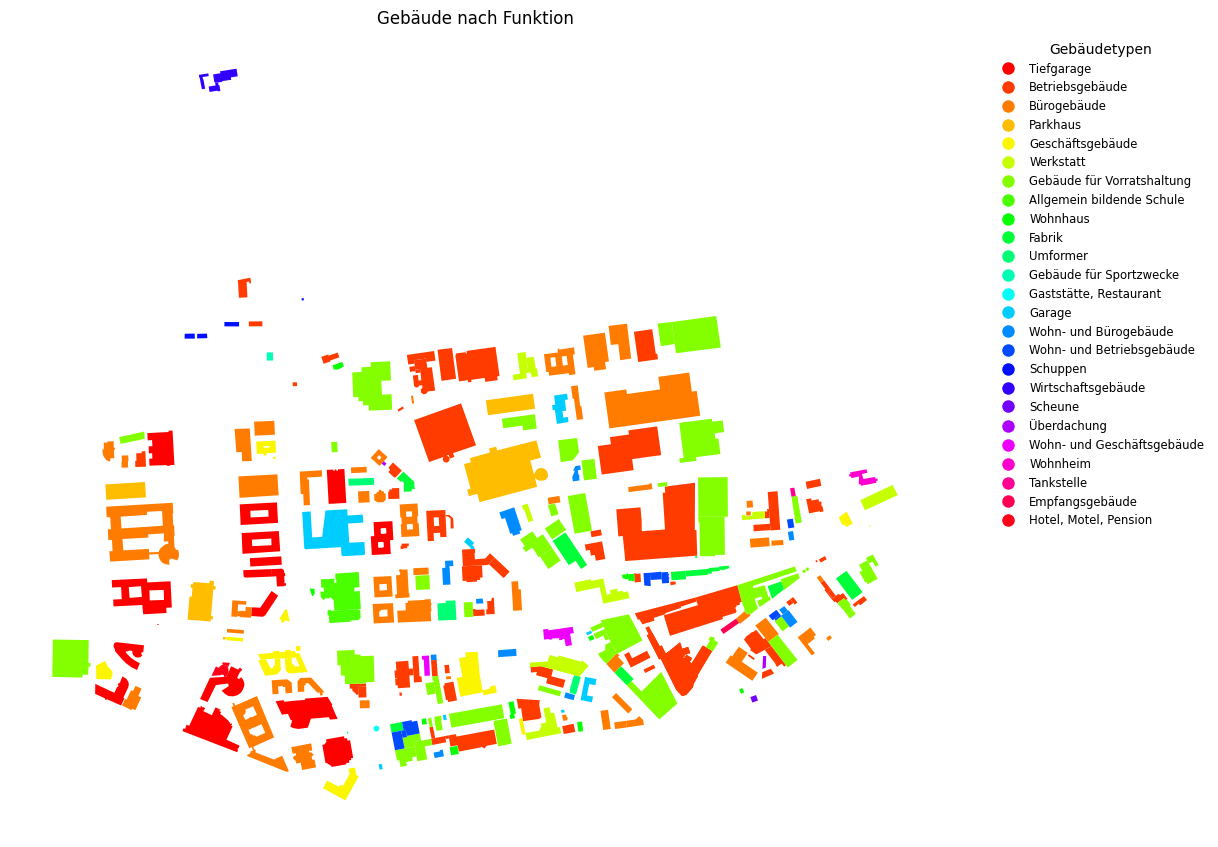

In [17]:
plot_building_functions(all_buildings_with_function,'function')

In [18]:
def get_Building_type_dataFrame(buildings_Data, building_type):
    buildingsDataFrame = gpd.GeoDataFrame()
    building_anz = 0
    for i in range(len(buildings_Data.building)):
        if buildings_Data.function.iloc[i] == building_type:
            building_anz += 1
            buildingsDataFrame = pd.concat([buildingsDataFrame, buildings_Data.iloc[[i],:]], ignore_index = False)
    return buildingsDataFrame, building_anz

In [19]:
office_buildings, office_anz = get_Building_type_dataFrame(buildings, 'office')    
industrial_buildings, industrial_anz = get_Building_type_dataFrame(buildings, 'industrial')
commercial_buildings, commercial_anz = get_Building_type_dataFrame(buildings, 'commercial')
warehouse_buildings, warehause_anz = get_Building_type_dataFrame(buildings, 'warehouse')
hotel_buildings, hotel_anz = get_Building_type_dataFrame(buildings, 'hotel')
residential_buildings, residential_anz = get_Building_type_dataFrame(buildings, 'residential')
apartment_buildings, apartment_anz = get_Building_type_dataFrame(buildings, 'apartments')
retail_buildings, retail_anz  = get_Building_type_dataFrame(buildings, 'retail')
yes_buildings, yes_anz = get_Building_type_dataFrame(buildings, 'yes')
house_buildings, house_anz = get_Building_type_dataFrame(buildings, 'house')

carport_buildings, carport_anz = get_Building_type_dataFrame(buildings, 'carport')
parking_buildings, parking_anz = get_Building_type_dataFrame(buildings, 'parking')

In [20]:
def sumFlaeche_and_kW_ds(buildings, sonstige=False):
    summ =0
    pw=0
    if sonstige == True:
        names=['industrial', 'office', 'yes', 'commercial']
        for i in range(len(buildings)):
            if buildings.building.iloc[i] not in names:
                summ += buildings.flaeche.iloc[i]
                pw += buildings.last_kW.iloc[i]
        summ = summ/len(buildings)
        pw = pw/len(buildings)
        print(f'Durchschnitt:{summ}, Max:{max(buildings.flaeche)}, Min:{min(buildings.flaeche)}')
        print(f'DLast:{pw}')
    else:
        for i in range(len(buildings)):
                summ += buildings.flaeche.iloc[i]
                pw += buildings.last_kW.iloc[i]
        summ = summ/len(buildings)
        pw = pw/len(buildings)
        print(f'Durchschnitt:{summ}, Max:{max(buildings.flaeche)}, Min:{min(buildings.flaeche)}')
        print(f'DLast:{pw}')
    return 

In [21]:
#Durschnittsfläche
#sumFlaeche_and_kW_ds(commercial_buildings, sonstige=False)
#min(buildings.last_kW)

In [22]:
def update_levels(gdf):
    # Überprüfen, ob die Spalte 'function' und 'levels' existieren
    if 'function' in gdf.columns and 'building:levels' in gdf.columns:
        # Filtern der Zeilen, die den Bedingungen entsprechen
        mask = gdf['function'].isin(['Betriebsgebäude', 'Bürogebäude']) & gdf['building:levels'].isnull()
        
        # Setzen des 'levels' Werts auf 3 für die gefilterten Zeilen
        gdf.loc[mask, 'building:levels'] = 3

        mask2 = gdf['building:levels'].isnull()
        
        # Setzen des 'levels' Werts auf 3 für die gefilterten Zeilen
        gdf.loc[mask2, 'building:levels'] = 1
    
    return gdf

#all_buildings_with_function = update_levels(all_buildings_with_function)

In [23]:
'''
0              Betriebsgebäude     70   0.00432  kW/m2  Wert aus Bundesanzeiger(40)
1                  Bürogebäude     52   0.00685  kW/m2  Wert aus VerbrauchPDF   0.00384 kW/m2 aus Bundesanzeiger (7)
2   Gebäude für Vorratshaltung     49   0.003    kW/m2  Wert aus DaVe  
3                   Tiefgarage     17
4             Geschäftsgebäude     14   0.00726  kW/m2  Wert aus Bundesanzeiger (43)
5        Wohn- und Bürogebäude     11   0.00429  kW/m2  Mittelwert von Wohn- und Bürogebäude
6                       Fabrik     10   0.00675  kW/m2  Wert aus Bundesanzeiger (41)
7                     Wohnhaus     10   0.002    kW/m2  Wert aus DaVe 
8                    Werkstatt      9   
9                       Garage      9
10   Wohn- und Betriebsgebäude      9   0.00316  kW/m2  Mittelwert von Wohn- und Betriebsgebäude
11                    Umformer      5
12                    Parkhaus      5
13                    Schuppen      4   0
14          Wirtschaftsgebäude      3
15  Wohn- und Geschäftsgebäude      2   0.00463  kW/m2  Mittelwert von Wohn- und Geschäftsgebäude
16                 Überdachung      2   0
17       Hotel, Motel, Pension      2   0.0514   kW/m2  Wert aus VerbrauchPDF, 12h pro Tag(Annahme)
18   Allgemein bildende Schule      2   0.00376  kW/m2  Wert aus Bundesanzeiger (21)
19                     Scheune      1   0
20     Gebäude für Sportzwecke      1
21                    Wohnheim      1   0.002    kW/m2  Wert Wohnhaus
22                  Tankstelle      1
23             Empfangsgebäude      1
24      Gaststätte, Restaurant      1   0,0094   kW/m2  Wert aus npro.energy
'''

'\n0              Betriebsgebäude     70   0.00432  kW/m2  Wert aus Bundesanzeiger(40)\n1                  Bürogebäude     52   0.00685  kW/m2  Wert aus VerbrauchPDF   0.00384 kW/m2 aus Bundesanzeiger (7)\n2   Gebäude für Vorratshaltung     49   0.003    kW/m2  Wert aus DaVe  \n3                   Tiefgarage     17\n4             Geschäftsgebäude     14   0.00726  kW/m2  Wert aus Bundesanzeiger (43)\n5        Wohn- und Bürogebäude     11   0.00429  kW/m2  Mittelwert von Wohn- und Bürogebäude\n6                       Fabrik     10   0.00675  kW/m2  Wert aus Bundesanzeiger (41)\n7                     Wohnhaus     10   0.002    kW/m2  Wert aus DaVe \n8                    Werkstatt      9   \n9                       Garage      9\n10   Wohn- und Betriebsgebäude      9   0.00316  kW/m2  Mittelwert von Wohn- und Betriebsgebäude\n11                    Umformer      5\n12                    Parkhaus      5\n13                    Schuppen      4   0\n14          Wirtschaftsgebäude      3\n15  W

| Index | Gebäudetyp| Anzahl | Verbrauch | Quelle |
| --- | --- | --- | --- | --- |
| 0 |             Betriebsgebäude   |  70  | 37.8  kWh/m2 | Wert aus Bundesanzeiger(40)|
| 1 |                 Bürogebäude   |  52  | 33.6  kWh/m2  |Wert aus VerbrauchPDF   0.00384 kW/m2 aus Bundesanzeiger (7)|
| 2 |  Gebäude für Vorratshaltung   |  49  | 60.1    kWh/m2  |Wert aus Bundesanzeiger(44)  |
| 3 |                  Tiefgarage   |  17  |27 kWh/m2| Google?|
| 4 |           Geschäftsgebäude    | 14   |60.1  kWh/m2 | Wert aus Bundesanzeiger (43)|
| 5 |       Wohn- und Bürogebäude   |  11  | 0.00429  kWh/m2 | Mittelwert von Wohn- und Bürogebäude|
| 6 |                      Fabrik   |  10  | 59.1  kWh/m2  |Wert aus Bundesanzeiger (41)|
| 7 |                    Wohnhaus   |  10  | 400 kWh + 600 kWh + 9kWh/m2  |Formel vom Bund der Energieverbraucher |
| 8 |                   Werkstatt   |   9  || |
| 9 |                      Garage   |   9|||
| 10 |  Wohn- und Betriebsgebäude   |   9 |  0.00316  kWh/m2 | Mittelwert von Wohn- und Betriebsgebäude|
| 11 |                   Umformer   |   5|0||
| 12 |                   Parkhaus   |   5|27 kWh/m2|siehe Tiefgarage|
| 13 |                   Schuppen   |   4 |  0||
| 14 |         Wirtschaftsgebäude   |   3|||
| 15 | Wohn- und Geschäftsgebäude   |   2|   0.00463  kWh/m2 | Mittelwert von Wohn- und Geschäftsgebäude|
| 16 |                Überdachung   |   2 |  0||
| 17 |      Hotel, Motel, Pension   |   2  | 120   kWh/m2 | Wert aus Bundesanzeiger (39)|
| 18 |  Allgemein bildende Schule   |   2  | 32.9  kWh/m2 | Wert aus Bundesanzeiger (21)|
| 19 |                    Scheune    |  1  | 0||
| 20 |    Gebäude für Sportzwecke    |  1|||
| 21 |                   Wohnheim    |  1 |  0.002    kWh/m2 | Wert Wohnhaus|
| 22 |                 Tankstelle    |  1 |||
| 23 |            Empfangsgebäude    |  1 |||
| 24 |     Gaststätte, Restaurant    |  1 |  0,0094   kWh/m2 | Wert aus npro.energy|


# Lastzuweisung

In [24]:
#Power zu allen beschriebenen Gebäudetypen zuweisen:
#OFFICES     : Wert aus VerbrauchPDF                       : 0.00685  kW/m2
#INDUSTRIALS : Wert aus DaVe                               : 0.01     kW/m2
#COMMERCIALS : Wert aus DaVe                               : 0.003    kW/m2 
#WAREHOUSES  : Wert aus DaVe                               : 0.003    kW/m2
#HOTELS      : Wert aus VerbrauchPDF, 12h pro Tag(Annahme) : 0.0514   kW/m2
#RESIDENTIALS: Wert aus DaVe                               : 0.002    kW/m2
#APARTMENTS  : Wert aus DaVe                               : 0.002    kW/m2
#RETAIL(1)   : Wert aus VerbrauchPDF                       : 0.0106   kW/m2
    #(1) Durschnittsverbrauch (Lebensmittel und Nicht-Lebensmittel Einzelhandel) : 92,78 kWh/m2a
#YES(Annahme): Wert aus DaVe (Bezogen auf Fläche unterschiedliche Werte) : 0.003 - 0.01 kW/m2

def addPower(buildings_Data): 
    buildings_power = []
    buildings_id = []
    for i in range(len(buildings_Data)):
        b = buildings_Data.function.iloc[i]
        buildings_id.append(i+1) 
        level = int(buildings_Data['building:levels'].iloc[i])
        if b == 'Betriebsgebäude':
            buildings_power.append(buildings_Data.flaeche.iloc[i] * level * 37.8)
            
        elif b == 'Bürogebäude':
            buildings_power.append(buildings_Data.flaeche.iloc[i] * level * 33.6)

        elif b == 'Tiefgarage':
            buildings_power.append(buildings_Data.flaeche.iloc[i] * level * 27)
                
        elif b == 'Gebäude für Vorratshaltung':
            buildings_power.append(buildings_Data.flaeche.iloc[i] * level * 60.1)
            
        elif b == 'Tiefgarage' or b == 'Parkhaus':
            buildings_power.append(buildings_Data.flaeche.iloc[i] * level * 60.1) # Wie Lager?
            
        elif b == 'Geschäftsgebäude':
            buildings_power.append(buildings_Data.flaeche.iloc[i] * level * 60.1)
        
        elif b == 'Wohn- und Bürogebäude':
            buildings_power.append(buildings_Data.flaeche.iloc[i] * level * 0.00429)
            
        elif b == 'Fabrik':
            buildings_power.append(buildings_Data.flaeche.iloc[i] * level * 59.1)
        
        elif b == 'Wohnhaus':
            buildings_power.append(buildings_Data.flaeche.iloc[i] * level * 9 + 1000)

        elif b == 'Schuppen' or b == 'Überdachung' or b == 'Scheune' or b == 'Umformer':
            buildings_power.append(buildings_Data.flaeche.iloc[i] * level * 0)

        else:
            buildings_power.append(buildings_Data.flaeche.iloc[i] * level * 45 )
        '''
        elif b == 'yes' or b == 'barn' or b == 'farm_auxiliary' or b == 'house' or b == 'detached' or b == 'service':
            #14277m^2 größtes; 5,7m^2 kleinstes (bei yes_buildings)# Durchschnittsfläche:1095.26m^2
            if buildings_Data.flaeche.iloc[i] <5000:
                buildings_power.append(buildings_Data.flaeche.iloc[i] * level * 0.00685)
            elif 5000 < buildings_Data.flaeche.iloc[i] < 10000:
                buildings_power.append(buildings_Data.flaeche.iloc[i] * level * 0.01)
            elif buildings_Data.flaeche.iloc[i] >10000:
                buildings_power.append(buildings_Data.flaeche.iloc[i] * level * 0.003)

        elif b == 'roof':
            buildings_power.append(buildings_Data.flaeche.iloc[i] * level * 0)
        elif b == 'parking':
            buildings_power.append(buildings_Data.flaeche.iloc[i] * level * 0)
        elif b == 'carport':
            buildings_power.append(buildings_Data.flaeche.iloc[i] * level * 0)
        '''
        
        #else: raise ValueError(f"Gebäudelast für den Gebäudetyp {buildings_Data.building.iloc[i]} nicht Definiert")
    
    buildings_Data.insert(loc=1, column='last_kWh', value=buildings_power)
    buildings_Data.insert(loc=1, column='ID', value=buildings_id)
    return buildings_Data

In [25]:
# gibt die Summierte Last von einem Gebäudetyp an
def getSumPower(buildings):
    summ = 0
    for i in range(len(buildings)):
        summ += buildings.last_kW.iloc[i]
    return summ

In [26]:
buildings = addPower(all_buildings_with_function)

In [27]:
def last_importieren(file):
    file_path = './Daten/TUB_Subsector_load_profiles_Branchenlastprofile_BLP/TUB Subsector load profiles (Branchenlastprofile - BLP)/'

    df = pd.read_csv(file_path + file, 
                    skiprows=2, 
                    header=None, 
                    names=['Datetime', 'Mean', '05', '95'], 
                    delimiter=';', 
                    decimal=',')
    
    hoechster_wert = df['Mean'].max()

    return df, hoechster_wert

In [28]:
def berechne_max_viertelstundenleistung_und_zeitreihe(jahresverbrauch, skalierungs_df, skalierungs_spaltenname = 'Mean'):
    # Berechnung der Viertelstundenverbrauch
    summe_skalierungsreihe = skalierungs_df[skalierungs_spaltenname].sum()
    skalierungs_df['normalisierte_skalierungswerte'] = skalierungs_df[skalierungs_spaltenname] / summe_skalierungsreihe
    skalierungs_df['viertelstunden_verbrauch'] = skalierungs_df['normalisierte_skalierungswerte'] * jahresverbrauch

    # Bestimmung des maximalen Viertelstundenverbrauchs und Umrechnung in Leistung
    max_viertelstunden_verbrauch = skalierungs_df['viertelstunden_verbrauch'].max()
    max_leistung = max_viertelstunden_verbrauch * 4  # Umrechnung von kWh in kW (viertelstündlich auf stündlich hochgerechnet)

    return max_leistung, skalierungs_df['viertelstunden_verbrauch'].values

In [29]:
last_buro, buro_max = last_importieren('WZ64-71_Bürobetriebe Weighted German Average  2018.csv')
last_einzelhandel, einzelhandel_max = last_importieren('WZ47_Einzelhandel Weighted German Average  2018.csv')
last_lager, lager_max = last_importieren('WZ52_Lagerei u. sonstige Verkehrsdienstleistungen Weighted German Average  2018.csv')
last_hotel, hotel_max = last_importieren('WZ55_Beherbergung Weighted German Average  2018.csv')

# Speicherung der Zeitreihen-Spalten
zeitreihe_df = pd.DataFrame(index=last_buro['Datetime'])
zeitreihe_list = []

for index, row in buildings.iterrows():
    gebaeude_id = row['ID']
    jahresverbrauch = row['last_kWh']
    type = row['function']
    # Berechnung der maximalen Leistungswerte und Zeitreihen für das aktuelle Gebäude
    if type == 'Bürogebäude' or type == 'Betriebsgebäude':
        max_leistung, viertelstunden_verbrauch = berechne_max_viertelstundenleistung_und_zeitreihe(jahresverbrauch, last_buro)
    elif type == 'Gebäude für Vorratshaltung':
        max_leistung, viertelstunden_verbrauch = berechne_max_viertelstundenleistung_und_zeitreihe(jahresverbrauch, last_lager)
    elif type == 'Geschäftsgebäude':
        max_leistung, viertelstunden_verbrauch = berechne_max_viertelstundenleistung_und_zeitreihe(jahresverbrauch, last_einzelhandel)
    elif type == 'Hotel, Motel, Pension':
        max_leistung, viertelstunden_verbrauch = berechne_max_viertelstundenleistung_und_zeitreihe(jahresverbrauch, last_hotel)
    else:
        max_leistung, viertelstunden_verbrauch = berechne_max_viertelstundenleistung_und_zeitreihe(jahresverbrauch, last_buro)
    # Speicherung des maximalen Leistungswerts im Buildings DataFrame
    buildings.at[index, 'last_kW'] = max_leistung
    
    # Speicherung der Zeitreihe in der Liste
    zeitreihe_list.append(pd.Series(viertelstunden_verbrauch, name=gebaeude_id))

# Kombiniere alle Zeitreihen-Spalten in einem DataFrame
zeitreihe_df = pd.concat(zeitreihe_list, axis=1)

index = 10079 #Anfang 16.4.2018
last_Fruehling = zeitreihe_df.iloc[index:index+672]


In [30]:

def create_sorted_table(gdf, attr1, attr2,attr3):
    """
    Erstellt eine Tabelle mit zwei Attributen eines GeoDataFrames und sortiert sie alphabetisch nach dem ersten Attribut.
    """
    if attr1 not in gdf.columns or attr2 not in gdf.columns:
        raise ValueError("Eines oder beide der angegebenen Attribute existieren nicht im GeoDataFrame.")
    
    # Erstelle eine Kopie des GeoDataFrame, um nur die relevanten Spalten zu behalten
    df = gdf[[attr1, attr2,attr3]].copy()
    
    # Sortiere die Tabelle alphabetisch nach dem ersten Attribut
    df_sorted = df.sort_values(by=attr1).reset_index(drop=True)
    
    return df_sorted

sorted_table = create_sorted_table(buildings, 'function', 'building','adr')
#sorted_table

In [31]:
buildings_power = getSumPower(buildings)
buildings_power

7235.651219976762

In [32]:
#Herausfinden welches Gebäude die höchste / zweit höchste / etc Last besitzt
for i in range(len(buildings)):
    if buildings.last_kW.iloc[i]==buildings['last_kW'].nlargest(2).iloc[-1]:
        print(buildings.iloc[i])

flaeche                                                 17640.013545
ID                                                                27
last_kWh                                              1333585.024019
geometry           POLYGON ((507775.55379304517 5407899.519351882...
nodes              [620782527, 620782517, 2716010182, 2716010183,...
building                                                      retail
building:levels                                                2.475
power                                                            NaN
ways                                                             NaN
function                                             Betriebsgebäude
adr                                                Turbinenstraße 17
last_kW                                                   284.398196
Name: (way, 48915015), dtype: object


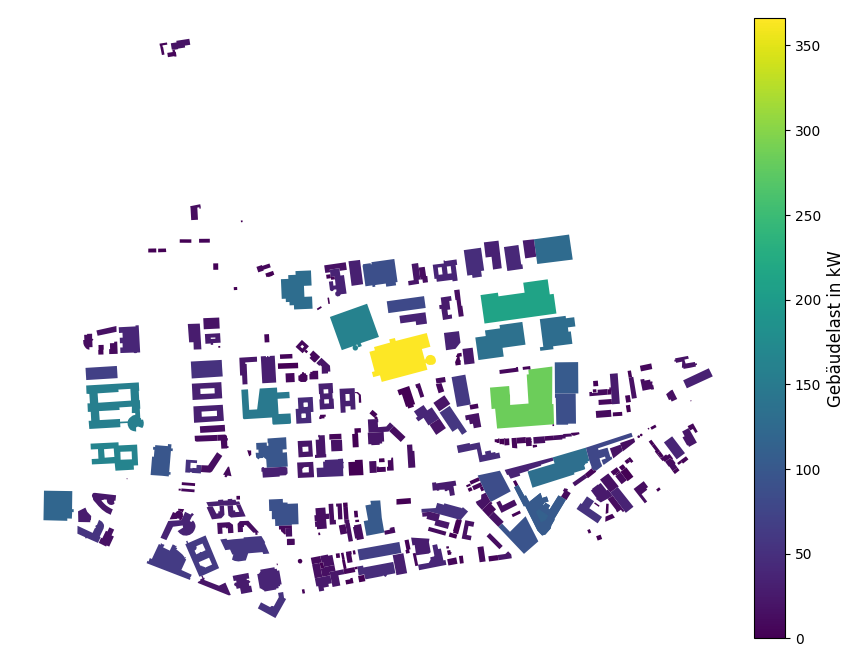

In [33]:
#Plot der heatmap gebäude
fig, ax = plt.subplots(figsize=(10, 10))
cmap = "viridis"
# Heatmap mit GeoDataFrame und last_kW als Farbzuweisung
buildings.plot(ax=ax, column="last_kW", cmap=cmap, legend=False)

# Farblegende hinzufügen
cbar = fig.colorbar(ax.collections[0], ax=ax, orientation='vertical', fraction=0.04, pad=0.01)
cbar.set_label("Gebäudelast in kW",fontsize=12)
ax.set_axis_off()

#plt.savefig(r'.\Daten\heatmap_erzeugung.png', format='png', bbox_inches='tight')
plt.show()
#print(buildings)

# Erzeugung von MaStR einbeziehen


In [34]:
def read_csv_select_columns(file_path, selected_columns):
# CSV Datei einlesen und nur Zeilen mit Koordinaten behalten
    try:
        # Daten aus CSV-Datei einlesen
        data = pd.read_csv(file_path,sep=";", decimal = ',')

        selected_data = data[selected_columns]

        # Nur ausgewählte Spalten behalten
        if 'Koordinate: Breitengrad (WGS84)' in selected_columns and 'Koordinate: Breitengrad (WGS84)' in data.columns:
            selected_data = selected_data[selected_data['Koordinate: Breitengrad (WGS84)'].notnull()]
        
        # Koordinaten zu geometry hinzufügen
        geometry = [Point(xy) for xy in zip ( selected_data['Koordinate: Längengrad (WGS84)'], selected_data['Koordinate: Breitengrad (WGS84)'])]
        gdf =  gpd.GeoDataFrame(selected_data, geometry=geometry)
        return gdf
    except Exception as e:
        print("Fehler beim Einlesen der CSV-Datei:", e)

In [35]:
# Daten von MaStR einlesen
file_path   = r".\Daten\Stromerzeuger.csv"
selected_columns = ['Nettonennleistung der Einheit','Koordinate: Breitengrad (WGS84)','Koordinate: Längengrad (WGS84)','Volleinspeisung oder Teileinspeisung','Spannungsebene']

PV_Anlagen = read_csv_select_columns(file_path,selected_columns)

# In passendes Koordinatensystem umwandeln
PV_Anlagen.crs = "EPSG:4326"
PV_Anlagen = PV_Anlagen.to_crs(epsg=25832)
# Koordinaten auf Polygon beschränken
PV_Anlagen_gefiltert = PV_Anlagen[PV_Anlagen.within(polygon_geometry)]

In [36]:
def nearest_polygon(point, polygons):
    nearest_geom = None
    min_distance = float('inf')
    for polygon in polygons:
        distance = point.distance(polygon)  # Berechnung des Abstands
        if distance < min_distance:
            nearest_geom = polygon
            min_distance = distance
    return nearest_geom, min_distance

In [37]:
def assign_points_to_buildings(buildings_gdf, points_gdf):
    """
    Weist Punkte den Gebäuden in einem GeodataFrame zu und fügt neue Spalten für
    Erzeugungsleistung und Netzanschluss zu den Gebäuden hinzu.

    Parameters:
        buildings_gdf (geopandas.GeoDataFrame): GeodataFrame mit Gebäuden.
        points_gdf (geopandas.GeoDataFrame): GeodataFrame mit Punkten, die den Gebäuden zugeordnet werden sollen.

    Returns:
        geopandas.GeoDataFrame: GeodataFrame mit den zugeordneten Punkten und den neuen Spalten für Erzeugungsleistung und Netzanschluss.
    """
    # Setze das Koordinatenbezugssystem auf EPSG 25832
    buildings_gdf = buildings_gdf.to_crs(epsg=25832)
    points_gdf = points_gdf.to_crs(epsg=25832)

    # Erzeuge neue Spalten für Erzeugungsleistung und Netzanschluss in buildings_gdf
    buildings_gdf['Erzeugungsleistung'] = 0.0  # Standardwert für Gebäude ohne zugeordnete Punkte
    buildings_gdf['Netzanschluss'] = ''     # Standardwert für Gebäude ohne zugeordnete Punkte

    # Gehe durch jede PV-Anlage
    for index, point in points_gdf.iterrows():
        found_building = False
        # Überprüfe, in welchem Gebäude der Punkt liegt
        for index, building in buildings_gdf.iterrows():
            if point.geometry.within(building.geometry):
                # Füge die Erzeugungsleistung der Anlage dem Gebäude hinzu
                buildings_gdf.at[index, 'Erzeugungsleistung'] += point['Nettonennleistung der Einheit']
                # Füge den Netzanschluss der Anlage dem Gebäude hinzu
                buildings_gdf.at[index, 'Netzanschluss'] += point['Spannungsebene'] + ','
                found_building = True
                break  # Beende die Schleife, wenn das Gebäude gefunden wurde
        
        # Wenn punkt nicht direkt in einem gebäude liegt wird er dem nächsten Gebäude zugeordnet
        if not found_building:
            nearest_poly, min_distance = nearest_polygon(point.geometry, buildings_gdf.geometry)
            for index, building in buildings_gdf.iterrows():
                if building.geometry.equals(nearest_poly):
                    # Füge die Erzeugungsleistung der Anlage dem Gebäude hinzu
                    buildings_gdf.at[index, 'Erzeugungsleistung'] += point['Nettonennleistung der Einheit']
                    # Füge den Netzanschluss der Anlage dem Gebäude hinzu
                    buildings_gdf.at[index, 'Netzanschluss'] += point['Spannungsebene'] + ','
                    break
        #print(buildings.Netzanschluss)    
    return buildings_gdf

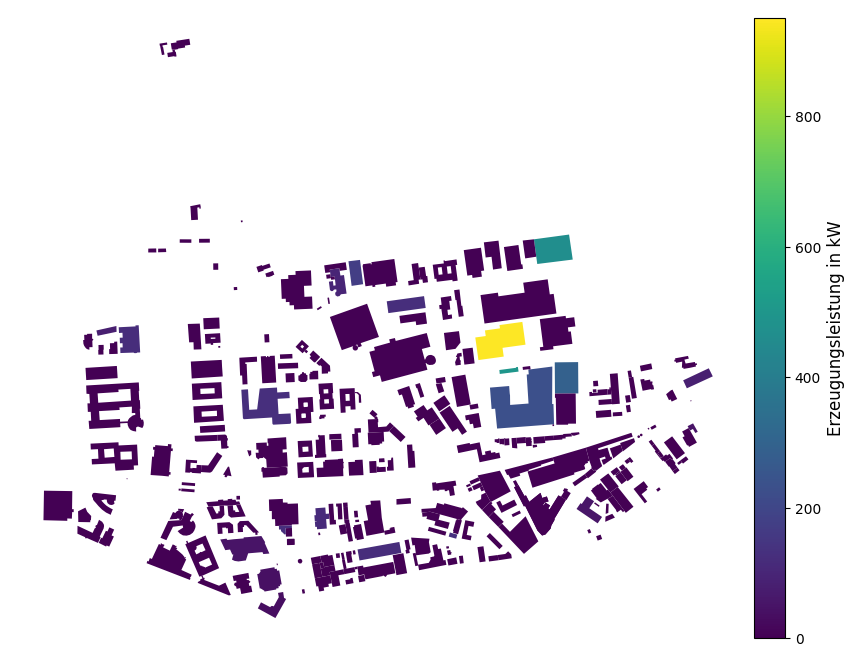

In [38]:
# PV-Anlagen zu den Gebäuden hinzufügen
buildings = assign_points_to_buildings(buildings, PV_Anlagen_gefiltert)

#Plot der heatmap gebäude
fig, ax = plt.subplots(figsize=(10, 10))
cmap = "viridis"

# Heatmap mit GeoDataFrame und Erzeugungsleistung als Farbzuweisung
buildings.plot(ax=ax, column="Erzeugungsleistung", cmap=cmap, legend=False,alpha=1)
#PV_Anlagen_gefiltert.plot(ax=ax, column="Nettonennleistung der Einheit", cmap=cmap, legend=False)

# Farblegende hinzufügen
cbar = fig.colorbar(ax.collections[0], ax=ax, orientation='vertical', fraction=0.04, pad=0.01)
cbar.set_label("Erzeugungsleistung in kW",fontsize=12)
ax.set_axis_off()

#plt.savefig(r'.\Daten\heatmap_erzeugung.png', format='png', bbox_inches='tight')
plt.show()


PV-Erzeugungskurven importieren

In [39]:
file_path = './Daten/PV-Einspeisungszeitreihen.xlsx'
sheets = ['Winter', 'Frühling', 'Sommer']

#Daten aus Excel auslesen
data = {sheet: pd.read_excel(file_path, sheet_name=sheet) for sheet in sheets}
columns_to_keep = ['Zeit','Erzeugung pro kWp'] 

# Erstellt separate Variablen für jedes Tabellenblatt
Winter_Erzeugung = data[sheets[0]][columns_to_keep]
Fruehling_Erzeugung = data[sheets[1]][columns_to_keep]
Sommer_Erzeugung = data[sheets[2]][columns_to_keep]

HS/MS-Trafo Importieren

In [40]:
# "Power" Gebäude importieren
power = ox.features.features_from_polygon(new_poly, tags={"power":True})
power.crs = "EPSG:4326"
power = power.to_crs(epsg=25832)

transformer = gpd.GeoDataFrame()

for i in range(len(power.power)):
    if power.power.iloc[i] == 'transformer' :
        transformer = pd.concat([transformer, power.iloc[[i],:]], ignore_index = False)


transformer = transformer[transformer.geometry.type == 'Point']
anz_transformer = len(transformer)

# Transformatoren Standorte
#fig, ax = plt.subplots(figsize=(10, 10))
#
#buildings.plot(ax=ax, legend=False,alpha=0.5)
#transformer.plot(ax=ax, legend=False)
#ax.set_axis_off()
#plt.show()


| Gebäudetyp| Durchschnittsfläche | Max | Min |
| --- | --- | --- | --- |
| unbekannt | 1095.26| 14277 | 5.76 |
| Industrie | 2060.7 | 8212 | 37.04 |
| Handel&Gewerbe| 2466.4 | 14773 | 114 |
| Büro | 1970 | 13306 | 337.3 |
| Lagerhaus | 2434 | 6348 | 374.3 |

# Cluster bestimmen & plotten

In [41]:
#Summiert alle Clusterzugehörigen Gebäudelasten auf
def get_cluster_power(nodes_w_cl):
    cl_anz = max(nodes_w_cl['cluster']+1)
    cl_power = [i for i in range(cl_anz)]
    
    for i in range(len(cl_power)+1):
        for j in range(len(nodes_w_cl)):
            if nodes_w_cl['cluster'].iloc[j] == i:
                cl_power[i] += nodes_w_cl['last_kW'].iloc[j]
            else: continue
    return cl_power

In [42]:
#Summiert alle Clusterzugehörigen Gebäudegeneratoren auf
def get_cluster_generation(nodes_w_cl):
    cl_anz = max(nodes_w_cl['cluster']+1)
    cl_power = [i for i in range(cl_anz)]
    
    for i in range(len(cl_power)+1):
        for j in range(len(nodes_w_cl)):
            if nodes_w_cl['cluster'].iloc[j] == i:
                cl_power[i] += nodes_w_cl['generation_kW'].iloc[j]
            else: continue
    return cl_power

In [43]:
#Ordnet Cluster ID zu
def get_cluster_id(nodes_w_cl):
    cl_anz = max(nodes_w_cl['cluster']+1)
    cl_id = [i for i in range(cl_anz)]
    
    for i in range(len(cl_id)+1):
        for j in range(len(nodes_w_cl)):
            if nodes_w_cl['cluster'].iloc[j] == i:
                cl_id[i] = nodes_w_cl['cluster'].iloc[j]
            else: continue
    return cl_id

In [44]:
def get_centroids_w_power_dataFrame(nodes, cl_centroids):
    points = []
    x = []
    y = []
    for i in range(len(cl_centroids)):
        x.append(cl_centroids[i-1][0])
        y.append(cl_centroids[i-1][1])
        points.append(Point(cl_centroids[i-1][0], cl_centroids[i-1][1]))
    cl_power = get_cluster_power(nodes)
    cl_generation = get_cluster_generation(nodes)
    cl_id = get_cluster_id(nodes)
    df = {'geometry':points,'osmid':np.nan, 'x':x, 'y':y, 'last_kW':cl_power,'generation_kW':cl_generation,'power_type': 'ONS','id':cl_id}
    dataFrame = gpd.GeoDataFrame(df)
    return dataFrame

In [45]:
#Plot der Cluster Punkte & Direkt-Anbindungen
def plot_Cluster(building, b_centroids, cl_centroids):
    f, ax = plt.subplots(1, figsize=(13,10))
    #ax.set_title("Clusters", fontsize=25)
    ax.set_axis_off()
    
    
    #Zentren der Cluster
    for i in range(len(cl_centroids)): #ONS sind X
        if cl_centroids.power_type.iloc[i] == 'ONS':
            ax.scatter(
                cl_centroids.x.iloc[i],
                cl_centroids.y.iloc[i],
                marker= "x",
                s=169,
                linewidths=3,
                color="blue",
                zorder=11,
            )
        else: #Direktanbindungen Dreiecke
            ax.scatter(
                cl_centroids.x.iloc[i],
                cl_centroids.y.iloc[i],
                marker= "v",
                s=80,
                linewidths=3,
                color="red",
                zorder=10,
            )
    building.plot(ax=ax, alpha=0.3, color ='orange', zorder=8)
    b_centroids.plot(column='cluster', cmap='Dark2', alpha=1, ax=ax, markersize=60, legend=False, label='Cluster Zentren',zorder=9)
    
    legend_elements = [
        Line2D([0], [0], marker='.', color='black', markersize=10, label='Cluster zugehörige Gebäude', linestyle='None'),
        Line2D([0], [0], marker='x', color='blue', markersize=10, label='Clustermitte / ONS', linestyle='None', markeredgewidth=2),
        Line2D([0], [0], marker='v', color='red', markersize=10, label='MS-Direktkunde', linestyle='None'),
        Patch(color='orange', alpha=0.3, label='Gebäudeumrisse')
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=12)
    cx.add_basemap(ax, alpha=0.6, crs=building.crs) #OSM Hintergrund
    #plt.savefig(r'.\Daten\Cluster3.png', format='png', bbox_inches='tight')
    plt.show()
    return

In [46]:
def create_cluster_timeseries(ons_nodes, last):
    # Erstellen eines leeren DataFrames für die clusterbasierten Zeitreihen
    cluster_timeseries = pd.DataFrame()
    
    # Iterieren über jede eindeutige Cluster-Nummer in ons_nodes
    for cluster in ons_nodes['cluster'].unique():
        # Extrahieren aller IDs, die zu diesem Cluster gehören
        cluster_ids = ons_nodes[ons_nodes['cluster'] == cluster]['id']
        
        # Selektieren der entsprechenden Zeitreihen im last DataFrame und summieren
        cluster_timeseries[cluster] = last[cluster_ids].sum(axis=1)
    
    return cluster_timeseries

In [47]:
def add_cluster_ids(ons_nodes):
    # Erstellen einer neuen Spalte für die aggregierten Cluster-IDs
    ons_nodes['id'] = ons_nodes.groupby('cluster')['id'].transform(lambda x: list(x))
    
    return ons_nodes

In [48]:
def get_k_means_cluster(buildings, last, ms_direkt, plot=False):    
    
    n_trafo = 0
    centroids = buildings.centroid
    lons = list(centroids.x)
    lats = list(centroids.y)
    coords = [[lons[i],lats[i]] for i in range(len(lons))]
    
    dictionary = dict()
    node_id = 0
    for i in range(len(coords)):
        node_id = buildings.index[i][1]
        dictionary[node_id] = {
        'x': lons[i],
        'y': lats[i],
        'last_kW':buildings.last_kW.iloc[i],
        'generation_kW':buildings.Erzeugungsleistung.iloc[i],
        'Netzanschluss':buildings.Netzanschluss.iloc[i],
        'ID':buildings.ID.iloc[i],
         }
    
    #Unterscheidung ob MS-Direktkunden vorhanden sind oder nicht
    tmp_list = []
    tmp_list_ms = []
    if ms_direkt == False:
        for item_key, item_value in dictionary.items():

                tmp_list.append({
                    'geometry' : Point(item_value['x'], item_value['y']),
                    'osmid': item_key,
                    'x' : item_value['x'],
                    'y' : item_value['y'],
                    'last_kW' : item_value['last_kW'],
                    'generation_kW' : item_value['generation_kW'],
                    'power_type': 'ONS'
                })
    #MS Direktkuden sind alle über 30kW Last
    else:
        for item_key, item_value in dictionary.items():
            if  item_value['last_kW'] > 135 or item_value['Netzanschluss'] == 'Mittelspannung,' or item_value['Netzanschluss'] == 'Umspannebene Mittelspannung/Niederspannung,':       #Woher kommen die 25/30KW?
                tmp_list_ms.append({
                    'geometry' : Point(item_value['x'], item_value['y']),
                    'osmid': item_key,
                    'x' : item_value['x'],
                    'y' : item_value['y'],
                    'last_kW' : item_value['last_kW'],
                    'generation_kW' : item_value['generation_kW'],
                    'power_type': 'MS_kunde',
                    'id': item_value['ID']
                })
            else: 
                tmp_list.append({
                    'geometry' : Point(item_value['x'], item_value['y']),
                    'osmid': item_key,
                    'x' : item_value['x'],
                    'y' : item_value['y'],
                    'last_kW' : item_value['last_kW'],
                    'generation_kW' : item_value['generation_kW'],
                    'power_type': 'ONS',
                    'id': item_value['ID']
                })
    ons_nodes = gpd.GeoDataFrame(tmp_list)
    ms_nodes = gpd.GeoDataFrame(tmp_list_ms) #MS Nodes werden später direkt angebunden

    #Anzahl der benötigten 630kVA Trafos
    ges_last = 0
    for i in range(len(tmp_list)):
        ges_last += tmp_list[i]['last_kW']
    n_trafo = math.ceil(ges_last*2/630)   #ges_last * 1/cos(phi)[(1/0.98)] * 2 um Trafos max. nur mit 50% zu belasten   
    #print(ges_last)
    
    # X & Y Werte der Geb_Centroids als Stacks speichern
    a = pd.Series(ons_nodes['geometry'].apply(lambda p: p.x))
    b = pd.Series(ons_nodes['geometry'].apply(lambda p: p.y))
    X = np.column_stack((a,b))
    kmeans = KMeans(n_clusters = n_trafo, init = 'k-means++', n_init=10, random_state =10, max_iter=10)
    y_kmeans = kmeans.fit_predict(X)
    k=pd.DataFrame(y_kmeans, columns=['cluster'])
    
    #Gebäude Zentren mit zugehörigem Cluster sowie Clusterzentrum
    ons_nodes = ons_nodes.join(k)
    cluster_timeseries_df = create_cluster_timeseries(ons_nodes, last)
    cl_centroids = kmeans.cluster_centers_
    cl_dataFrame = get_centroids_w_power_dataFrame(ons_nodes, cl_centroids)
    dataFrame = pd.concat([cl_dataFrame, ms_nodes], ignore_index=True)
    if plot == True:
        #plot_Cluster(buildings, ons_nodes, dataFrame) 
        
        return dataFrame, cluster_timeseries_df
    
    else: return dataFrame, cluster_timeseries_df
    

In [49]:
building_stations, cluster_timeseries_df = get_k_means_cluster(buildings, last_Fruehling, ms_direkt=True, plot=True)

#yes_stations = get_k_means_cluster(yes_buildings, ms_direkt=True, plot=False)
#office_stations = get_k_means_cluster(office_buildings, ms_direkt=True, plot=False)
#industrial_stations = get_k_means_cluster(industrial_buildings, ms_direkt=True, plot=False)
#warehouse_stations = get_k_means_cluster(warehouse_buildings, ms_direkt=True, plot=True)

# Synthetische Knoten für Anbindung

In [50]:
# Ding0 Code für Synthetische Knoten
def line_shp_from_node_pair(graph, u, v):

    line_shp = LineString([(graph.nodes[u]['x'], graph.nodes[u]['y']),
                           (graph.nodes[v]['x'], graph.nodes[v]['y'])])

    return line_shp

def subdivide_graph_edges(inner_graph): #(inner_graph, inner_node_list):

    """
    subdivide_graph_edges by defined distance value get_config_osm('dist_edge_segments')
    and build new graph considering subdivided edges with additional synthetic nodes.
    TODO: keep information about edge name
          ensure edge name does not exist when adding
    """ 

    graph_subdiv = inner_graph.copy()
    edges = inner_graph.edges()
    edge_data = []
    node_data = []
    unique_syn_nodes = []
    origin_vertices = []
    syn_node_dist = 30 #Abstand der Knoten in m
    
    for u,v in edges:

        origin_vertices.append((v,u))

        if (u,v) in origin_vertices:
            pass
        else:

            linestring = line_shp_from_node_pair(inner_graph, u, v)
            vertices_gen = ox.utils_geo.interpolate_points(linestring, syn_node_dist) #### config
            vertices = list(vertices_gen) 
            highway = inner_graph.edges[u,v,0]['highway']
            osmid = inner_graph.edges[u,v,0]['osmid']
            # fromid = graph.edges[u,v,0]['from'] ### PAUL
            # toid = graph.edges[u,v,0]['to'] ### PAUL
            edge_id = u + v
            vertex_node_id = []

            for num,node in enumerate(list(vertices)[1:-1], start=1):
                x,y = node[0],node[1] ###

                # ensure synthetic node id does not exist in graph.
                # increment name by 1 if exist and check again
                skip_num_by=0
                while True:

                    # first name edge_id + 0 + 1(=num) + 0(=skip_num_by)
                    concat_0 = 0 # todo: check concat_0 is to change. check if node name needs to be str
                    name = int(str(edge_id) + str(concat_0) + str(num+skip_num_by))
                    if name in unique_syn_nodes: #graph_subdiv.nodes():

                        skip_num_by +=1
                        name = int(str(edge_id) + str(concat_0) + str(num+skip_num_by)) ####

                    else:

                        break

                node_data.append([name,x,y,(u,v)])
                vertex_node_id.append(name)
                unique_syn_nodes.append(name)

            if vertices[0] == (inner_graph.nodes[v]['x'],inner_graph.nodes[v]['y']): ###
                vertex_node_id.insert(0, v)
                vertex_node_id.append(u)
            else:
                vertex_node_id.insert(0, u)
                vertex_node_id.append(v)

            for i,j in zip(range(len(list(vertices))-1), range(len(vertex_node_id)-1)):
                line = LineString([vertices[i], vertices[i+1]])
                edge_data.append([vertex_node_id[j], vertex_node_id[j+1], line, line.length, highway, osmid])

    #build new graph 
    graph_subdiv.remove_edges_from(edges)

    for u,v,line,leng,highway,osmid in edge_data:
        graph_subdiv.add_edge(u,v,geometry=line,length=leng,highway=highway,osmid=osmid)
        graph_subdiv.add_edge(v,u,geometry=line,length=leng,highway=highway,osmid=osmid)

    for name,x,y,pos in node_data:
        graph_subdiv.add_node(name,x=x,y=y,node_type='synthetic')

    return graph_subdiv #graph_subdiv, edges

In [51]:
proj_graph = ox.project_graph(streets_graph_poly, to_crs=25832)
syn_node_graph = subdivide_graph_edges(proj_graph)

In [52]:
#ox.plot_graph(syn_node_graph)

# Anbinden der Verbraucher

In [53]:
#osmid der Geb. centroids
#for i in range(len(centroids)):
#    print(centroids.index[i][1])

In [54]:
#Anbindung von Knoten an den nächstgelegenen Knoten im Graphen

def connect_nodes_to_graph(graph, nodes):   #nodes als DataFrame
    graph_copy = graph.copy()
    return_graph = graph.copy()
    nameID = int(str(0))
    for i in range(len(nodes)):
        node_x = nodes.x.iloc[i]
        node_y = nodes.y.iloc[i]
        incident_node_id, leng = ox.distance.nearest_nodes(graph_copy, node_x, node_y, return_dist=True)
        incident_node_location = graph_copy.nodes(data=True)[incident_node_id]
        incident_node = tuple(incident_node_location)
        nameID = int(str(i+1))
        #print(nameID)
        
        """
        TODO:
        evtl. statt Nummerierung von 1 bis n: IDs von incident+1 sofern nicht schon vorhanden.
        Ansonsten so oft um 1 erhöhen bis Nummer verfügbar
        """
        ix = incident_node_location['x']
        iy = incident_node_location['y']
        geom1_2= LineString([[ix,iy], [node_x, node_y]])
        geom2_1= LineString([[node_x, node_y],[ix,iy]])
        
        power = nodes.last_kW.iloc[i]
        generation = nodes.generation_kW.iloc[i]
        id = nodes.id.iloc[i]
        if nodes.power_type.iloc[i] == 'ONS':
            return_graph.add_node(nameID,x=node_x,y=node_y,node_type='ONS', last_kW = power,generation_kW = generation,ONS_id = id)
            return_graph.add_edge(incident_node_id, nameID, length=leng, highway='connecting',geometry=geom1_2)
            return_graph.add_edge(nameID, incident_node_id, length=leng, highway='connecting',geometry=geom2_1)
        elif nodes.power_type.iloc[i] == 'MS_kunde':
            return_graph.add_node(nameID,x=node_x,y=node_y,node_type='MS_kunde', last_kW = power,generation_kW = generation,MS_id = id)
            return_graph.add_edge(incident_node_id, nameID, length=leng, highway='connecting',geometry=geom1_2)
            return_graph.add_edge(nameID, incident_node_id, length=leng, highway='connecting',geometry=geom2_1)
        elif nodes.power_type.iloc[i] == 'extGrid':
            gridNameID = int(str(0))
            return_graph.add_node(gridNameID,x=node_x,y=node_y,node_type='extGrid', last_kW = power,generation_kW = generation)
            return_graph.add_edge(incident_node_id, gridNameID, length=leng, highway='connecting',geometry=geom1_2)
            return_graph.add_edge(gridNameID, incident_node_id, length=leng, highway='connecting',geometry=geom2_1)
    return return_graph

In [55]:
#Ext. Netz Punkt zu "noch anzubindenden" Nodes hinzufügen

extG_point = transformer.geometry.iloc[1]
#Point(507116.000, 5408325.900)
tmp_list_extG = []
tmp_list_extG.append({
                    'geometry' : extG_point,
                    'osmid': 0,
                    'x' : extG_point.x,
                    'y' : extG_point.y,
                    'last_kW' : 0,
                    'power_type': 'extGrid'})

extGrid = gpd.GeoDataFrame(tmp_list_extG)
Station_nodes = pd.concat([building_stations, extGrid], ignore_index=True)

In [56]:
ring2 = [
    (9.09642, 48.82548,'ONS',0,0), #ONS
    (9.09451, 48.82579,'MS_kunde',0,0),
    (9.09253, 48.82534,'MS_kunde',0,0),
    (9.093390557850778, 48.82275138605339,'MS_kunde',0,0),
    (9.09500, 48.82490,'MS_kunde',0,0),
    (9.09476, 48.82430,'MS_kunde',0,0),
    (9.09506, 48.82377,'MS_kunde',0,0),
    (9.09449, 48.82356,'ONS',0,0),    #ONS
    (9.09473789333311, 48.824291535510966,'MS_kunde',0,0), #?
    (9.099387375418354, 48.82432191511985,'MS_kunde',0,0),
    (9.100086828835272, 48.824202903869306,'MS_kunde',0,0),
    (9.09932, 48.82428,'MS_kunde',0,0),
    #(9., 48.), #ANCAVA?
    (9.09751, 48.82277,'MS_kunde',0,0),
    (9.09813, 48.82476,'MS_kunde',0,0)
]

temp_df = pd.DataFrame(ring2, columns=['x', 'y','power_type','osmid','last_kW'])
geometry = [Point(xy) for xy in zip(temp_df['x'], temp_df['y'])]
ring2_anschluss = gpd.GeoDataFrame(temp_df, geometry=geometry)

#CRS von geometry und x und y setzen
ring2_anschluss.crs = "epsg:4326"
ring2_anschluss = ring2_anschluss.to_crs(epsg=25832)
ring2_anschluss.x = ring2_anschluss.geometry.x
ring2_anschluss.y = ring2_anschluss.geometry.y

ring3 = [
    #(9., 48.),
    #(9., 48.),
    #(9., 48.),
    (9.091655733241167, 48.82140730646622,'ONS',0,0), #ONS
    (9.09357952249625, 48.82042157650773,'MS_kunde',0,0),
    (9.094114678795624, 48.821565106539545,'MS_kunde',0,0),
    (9.094854918163259, 48.820463549109476,'MS_kunde',0,0),
    (9.095338234787699, 48.819727421217145,'MS_kunde',0,0),
    (9.096499589973652, 48.82032223992592,'ONS',0,0), #ONS
    (9.097314961587479, 48.819951203657325,'MS_kunde',0,0),
    (9.09739164741596, 48.81922352064199,'MS_kunde',0,0),
    (9.095780817934816, 48.82304006405927,'ONS',0,0), #ONS
    (9.095197511766784, 48.82145433771538,'MS_kunde',0,0),
    (9.097381168327338, 48.82389620741762,'MS_kunde',0,0)
]
temp_df2 = pd.DataFrame(ring3, columns=['x', 'y','power_type','osmid','last_kW'])
geometry2 = [Point(xy) for xy in zip(temp_df2['x'], temp_df2['y'])]
ring3_anschluss = gpd.GeoDataFrame(temp_df2, geometry=geometry2)

#CRS von geometry und x und y setzen
ring3_anschluss.crs = "epsg:4326"
ring3_anschluss = ring3_anschluss.to_crs(epsg=25832)
ring3_anschluss.x = ring3_anschluss.geometry.x
ring3_anschluss.y = ring3_anschluss.geometry.y

#Alle Nodes aus Ring 2 und 3
Weilimdorf = pd.concat([ring2_anschluss,ring3_anschluss],ignore_index=True)

#Nodes für Zusammenhängenden Graphen
Station_nodes2 = pd.concat([ring2_anschluss,ring3_anschluss,extGrid],ignore_index=True)

c:\Python310\lib\site-packages\geopandas\array.py:1459: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as ETRS89 / UTM zone 32N (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))


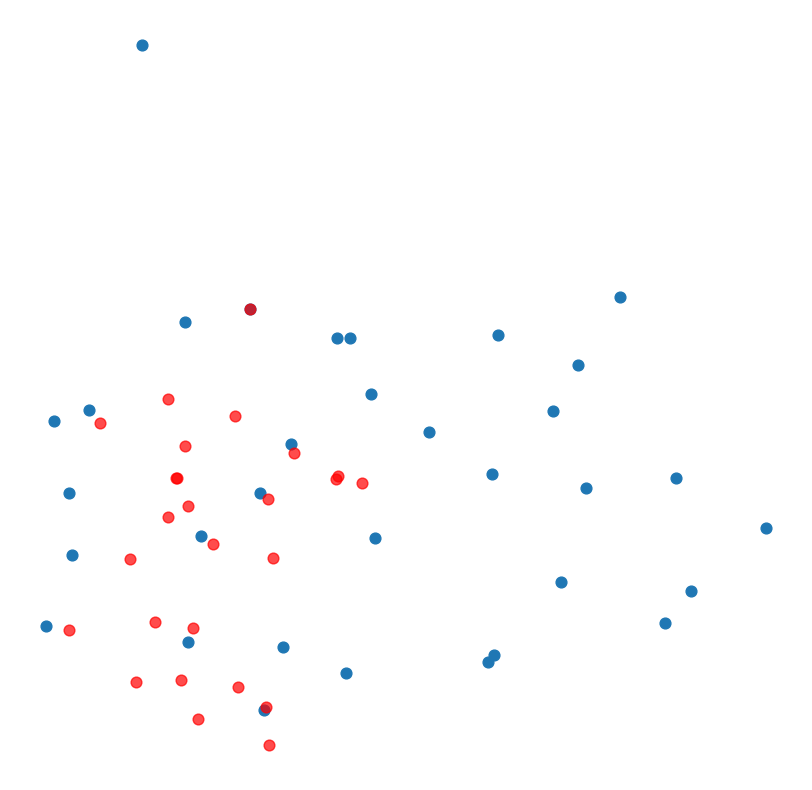

In [57]:
#Plot
f, ax = plt.subplots(1, figsize=(13,10))
ax.set_axis_off()
  
Station_nodes.plot( alpha=1, ax=ax, markersize=60, legend=False, zorder=9)
Station_nodes2.plot( alpha=0.7, ax=ax, markersize=60, color="red", legend=False,zorder=9) 
#cx.add_basemap(ax, alpha=0.6, crs=Station_nodes2.crs) #OSM Hintergrund
plt.show()
#Station_nodes2


In [58]:

connected_graph = connect_nodes_to_graph(syn_node_graph, Station_nodes)


In [59]:
#g = ox.simplification.simplify_graph(connected_graph,strict=True, remove_rings=True, track_merged=False)
g = connected_graph.copy()
#ox.plot_graph(g)


In [60]:
#ding0 Code zur Vereinfachung des Graphen (loops und parallele -überflüssige Wege- entfernen)
def remove_parallels_and_loops(G):
    """
    remove the parallel edge with greater "weight" attribute value
    remove selfloop_edges
    src: https://github.com/gboeing/osmnx/blob/main/osmnx/utils_graph.py#L341
    """
    # from https://github.com/gboeing/osmnx/blob/main/osmnx/utils_graph.py#L341
    #G = G.copy()
    to_remove = []

    # identify all the parallel edges in the MultiDiGraph
    parallels = ((u, v) for u, v, k in G.edges(keys=True) if k > 0)

    # remove the parallel edge with greater "weight" attribute value
    for u, v in set(parallels):
        k, _ = max(G.get_edge_data(u, v).items(), key=lambda x: x[1]['length'])
        to_remove.append((u, v, k))

    G.remove_edges_from(to_remove)
    G.remove_edges_from(nx.selfloop_edges(G))
    return G

In [61]:
#g_simplified = ox.simplification.simplify_graph(g)
#remove_parallels_and_loops(g)
#ox.plot_graph(g)

# Graphrouting 

In [62]:
#Distanz Matrix
def get_dist_matrix(graph, nodes):
    n_nodes = len(nodes)+1
    dist_matrix = np.zeros((n_nodes,n_nodes))
    for i in range(n_nodes):
        for j in range(n_nodes):
            if j == i:
                continue
            dist= nx.shortest_path_length(graph, i, j, weight='length')
            dist_matrix[i][j] = dist
    return dist_matrix

In [63]:
print(extGrid['x'])

0    507108.657992
Name: x, dtype: float64


In [64]:
def get_Data_vrp(graph, cluster_stations, net_x, net_y, line_capacity, n_lines):
    matrix = get_dist_matrix(graph, cluster_stations)
    lasten, lons, lats = list(), list(), list()
    vehicle_capacities = []
    for i in range(n_lines):
        vehicle_capacities.append(line_capacity)
        
    #extGrid at index 0
    lasten.append(0) 
    lons.append(net_x) #extGrid x
    lats.append(net_y) #extGrid y
    
    for i in range(len(cluster_stations)):
        lasten.append(cluster_stations.last_kW[i])
        lons.append(cluster_stations.x[i])
        lats.append(cluster_stations.y[i])
    Data = dict({
    'distance_matrix': matrix,
    'demands': lasten,
    'vehicle_capacities': vehicle_capacities,
    'lats': lats,
    'longs': lons
    })
    return Data

In [65]:
#building_stations
#Weilimdorf
#ring2_anschluss
#ring3_anschluss

In [66]:
#extG_point x= 507116.000, y= 5408325.900)# line_capacity = 1,5MW or 3MW
Data = get_Data_vrp(g, building_stations, extGrid['x'], extGrid['y'], line_capacity=3000, n_lines=20)

License for VeRyPy

MIT License

Copyright (c) 2019 Jussi Rasku

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

In [67]:
#Code aus https://github.com/yorak/VeRyPy/blob/master/examples/solve_from_data_dict.py
#VRP Solve Python Package: VeRyPy
from verypy.classic_heuristics.parallel_savings import parallel_savings_init
from verypy.util import sol2routes
from verypy.cvrp_ops import normalize_solution, recalculate_objective

def check_symmetric(A, tol=1e-8):
    """ Helper function to check if a matrix is symmetric. """
    return np.all(np.abs(A-A.T) < tol)

### 1. Convert data to VeRyPy format ###
C = Data['vehicle_capacities'][0]
assert \
    all( vC==C for vC in Data['vehicle_capacities']),\
    "VeRyPy requies all vehicles to have the same capacity"
points = list(zip(Data['lats'], Data['longs']))
D = np.array( Data['distance_matrix'] )
d = Data['demands']
assert \
    len(points) == len(d) == D.shape[0] == D.shape[1],\
    "Coordinates, demands, and the distance matrix have to have same number of elements"
assert \
    check_symmetric(D),\
    "VeRyPy only supports symmetric distances"

### 2. Solve the problem using parallel_savings algorithm from VeRyPy ###
sol = parallel_savings_init(D, d, C)
sol = normalize_solution(sol)

In [68]:
routes = sol2routes(sol)
for route_idx, route in enumerate(routes):
    print("Route #%d : %s"%(route_idx+1, route))

Route #1 : [0, 11, 13, 3, 9, 16, 32, 31, 15, 23, 0]
Route #2 : [0, 17, 19, 18, 21, 26, 12, 25, 10, 22, 5, 20, 0]
Route #3 : [0, 28, 24, 6, 27, 8, 1, 30, 7, 4, 2, 14, 29, 0]


In [69]:
#Entferne die überflüssigen Conecting Nodes zwischen den Verbrauchern
def remove_connecting_nodes(graph, route):
    res_graph = graph.copy()
    to_del_nodes=[]
    used_elements = 0
    elements_to_use = len(route)
    for j in range(len(route)):
        used_elements+=1
        if used_elements==elements_to_use:
            continue
        else:
            route_path = nx.shortest_path(graph, route[j], route[j+1], weight='length')
            coordinates=[]
            for i in range(len(route_path)-1):
                #Linestrings
                L_coords = graph[route_path[i]][route_path[i+1]][0]['geometry'].coords
                coordinates.extend(L_coords)

            part_geom = LineString(coordinates)
            #Neue Kante direkt zwischen Verbrauchern/Knoten
            res_graph.add_edge(route_path[0], route_path[len(route_path)-1], geometry=part_geom, length=part_geom.length)
            
            #Überflüssige Verbindungsknoten entfernen
            sublist = route_path[1:-1]
            for element in sublist:
                if element in to_del_nodes:
                    continue
                else: to_del_nodes.append(element)
        res_graph.remove_nodes_from(to_del_nodes)
    return res_graph

In [70]:
def get_routed_graphs(graph, routes):
    routed_graphs = []
    
    for i in range(len(routes)):
        routed_graph = graph.copy()
        edges_to_keep = []
        route_path = []
        used_elements = 0
        elements_to_use = len(routes[i])
        for j in range(len(routes[i])):
            used_elements+=1
            if used_elements==elements_to_use:
                continue
            else: 
                route_path = nx.shortest_path(graph, routes[i][j], routes[i][j+1], weight='length')
                for j, r in enumerate(route_path[:-1]):
                    edges_to_keep.append((r, route_path[j + 1]))
        edges_to_del = []
        grid_node = 0
        for edge in list(graph.edges()):
            if edge not in edges_to_keep:
                if grid_node not in edge:
                    edges_to_del.append(edge)
        routed_graph.remove_edges_from(edges_to_del)

        for loose_components in list(nx.weakly_connected_components(routed_graph)):
            if len(loose_components) == 1:  # there is only one not conencted node
                for node in loose_components:
                    routed_graph.remove_node(node)
        routed_graph = ox.simplification.simplify_graph(routed_graph)
        
        #Überflüssige Verbindungsknoten entfernen
        res_routed_graph = remove_connecting_nodes(routed_graph, routes[i])
        
        routed_graphs.append(res_routed_graph)
        
    return routed_graphs

In [71]:
routed_graphs = get_routed_graphs(g, routes)

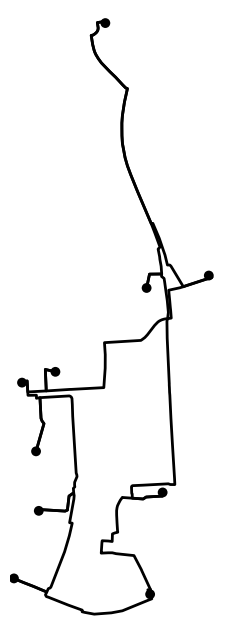

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [72]:
ox.plot_graph(routed_graphs[0], bgcolor='white', edge_color='black', edge_linewidth=2, node_color='black', node_size=50)

# PandaPower Netzmodell

In [73]:
net1 = pp.create.create_empty_network(name='Net1_Weilimdorf', f_hz=50.0, sn_mva=10, add_stdtypes=True)

In [74]:
#fügt einen 0.1MVA Trafo zu den Standardtypes hinzu
#bisher selbe Werte wie 0.25MVA nur sn_mva wurde zu 0.1 geändert
trafo_data=pp.load_std_type(net1, name="0.25 MVA 10/0.4 kV", element='trafo')
newTrafo_data= trafo_data.copy()
newTrafo_data['sn_mva']=0.1
pp.create_std_type(net1, newTrafo_data, name="0.1 MVA 10/0.4 kV", element='trafo')

In [75]:
#Fügt alle Nodes dem PP-Netzwerk hinzu. Bei Nodes mit Last wird ein extra Bus 
#mit Last hinzugefügt und der entsprechende Trafo dazwischen geschaltet
def createBusNodes_andPower(net, nodes, pv, last_ons, ring=0, bus_list = []):
    ONSid, MSid, ConBid, LastBid = 0, 0, 0, 0
    for i in range(len(nodes)):
        sublist=[item[1] for item in bus_list]
        n = nodes.node_type.iloc[i]
        n_id = nodes.index[i]
        if 'ONS_id' in nodes.columns:
            ONS_id = nodes.ONS_id.iloc[i]
        if 'MS_id' in nodes.columns:
            MS_id = nodes.MS_id.iloc[i]
        last = last_ons/1000
        if n_id in sublist:
            continue
        else:
            power = nodes.last_kW.iloc[i]/1000 #in MW
            g_power = nodes.generation_kW.iloc[i]/1000 * pv
            nodeX = nodes["x"].iloc[i]
            nodeY = nodes["y"].iloc[i]
            if n == 'synthetic': 
                b = pp.create_bus(net, vn_kv=10, name=f"Connecting Bus {ConBid}", zone=-1, geodata=(nodeX,nodeY))
                bus_list.append([b, n_id])
                ConBid+=1 
            elif n == 'ONS':
                b = pp.create_bus(net, vn_kv=10, name=f"ONS {ONSid} im Ring {ring}", zone=ring, geodata=(nodeX,nodeY))
                power_bus = pp.create_bus(net, vn_kv=0.4, name=f"Last_bus {LastBid} im Ring {ring}", zone=ring, geodata=(nodeX-10,nodeY-50))
                bus_list.append([b,n_id])
                pp.create_transformer(net, b, power_bus, std_type="0.63 MVA 10/0.4 kV", zone=ring, name=f"ONS Trafo{ONSid}")
                pp.create_load(net, power_bus, p_mw=last[ONS_id], zone=ring, name=f'Kumulierte Last an ONS {ONSid}')
                sgen_index = pp.create_sgen(net, power_bus, p_mw = g_power, zone = ring  , name =f'Kumulierte Erzeugung an ONS {ONSid}')
                ONSid+=1
                LastBid+=1
            elif n == 'MS_kunde':
                b = pp.create_bus(net, vn_kv=10, name=f"MS_Kunde {MSid} im Ring {ring}", zone=ring, geodata=(nodeX,nodeY))
                power_bus = pp.create_bus(net, vn_kv=0.4, name=f"Last_bus {LastBid} im Ring {ring}", zone=ring, geodata=(nodeX-10,nodeY-50))
                bus_list.append([b,n_id])
                pp.create_load(net, power_bus, p_mw=power, zone=ring, name=f'Kundendirektlast an MS_Kunde {MSid} im Ring {ring}')
                sgen_index = pp.create_sgen(net, power_bus, p_mw = g_power, zone = ring  , name =f'Kumulierte Erzeugung an ONS {ONSid}')
                if power>0.125:#MW
                    pp.create_transformer(net, b, power_bus, std_type="0.4 MVA 10/0.4 kV", zone=ring, name=f"MS_Kunden Trafo{MSid} im Ring {ring}")
                elif 0.05 < power < 0.125: #MW
                    pp.create_transformer(net, b, power_bus, std_type="0.25 MVA 10/0.4 kV", zone=ring, name=f"MS_Kunden Trafo{MSid} im Ring {ring}")
                else: pp.create_transformer(net, b, power_bus, std_type="0.1 MVA 10/0.4 kV", zone=ring, name=f"MS_Kunden Trafo{MSid} im Ring {ring}")
                MSid+=1
                LastBid+=1
            elif n == 'extGrid':
                b = pp.create_bus(net, vn_kv=10, name=f"extGrid", zone=-1, geodata=(nodeX,nodeY))
                bus_list.append([b,n_id])
                pp.create_ext_grid(net, b)
            else:
                b = pp.create_bus(net, vn_kv=10, name=f"Connecting Bus {ConBid}", zone=-1, geodata=(nodeX,nodeY))
                bus_list.append([b, n_id])
                ConBid+=1
    return bus_list

In [76]:
#Hilfsfunktion zum herausfinden welche PP BusID zur Node_OSMid gehört
def get_busID(bus_list, osmid):
    for i in range(len(bus_list)):
        if bus_list[i][1]==osmid:
            return bus_list[i][0]
    raise ValueError(f"Bus existiert nicht")

In [77]:
#Fügt alle Kanten als MS-Kabel zum Netz hinzu
def createPowerLines(net, graph, bus_list, ring=None):
    gdf = ox.graph_to_gdfs(graph, nodes=False, edges=True)
    l_index=0
    for edge in list(graph.edges()):
        length = gdf.length.iloc[l_index]
        geom = list(gdf.geometry.iloc[l_index].coords)
        u = get_busID(bus_list, edge[0])
        v = get_busID(bus_list, edge[1])    
        pp.create_line(net, u, v, length_km=length/1000, std_type="NA2XS2Y 1x150 RM/25 6/10 kV", name=f'Leitung in Ring {ring}', zone=ring, geodata=geom)
        l_index+=1
    return

In [78]:
def delete_all_components(net):
    # Alle Busse löschen
    net.bus.drop(net.bus.index, inplace=True)
    
    # Alle Erzeugungen löschen
    net.gen.drop(net.gen.index, inplace=True)
    net.sgen.drop(net.sgen.index, inplace=True)
    net.storage.drop(net.storage.index, inplace=True)

    # Alle Lasten löschen
    net.load.drop(net.load.index, inplace=True)
    
    # Alle Leitungen löschen
    net.line.drop(net.line.index, inplace=True)
    
    # Alle externen Netze löschen
    net.ext_grid.drop(net.ext_grid.index, inplace=True)

In [79]:
def initialize_network():
    # Erstellen eines neuen leeren Netzwerks
    return pp.create_empty_network()

In [80]:
def extract_results(net):
    # Maximale Belastung der Kabel (in %)
    max_line_loading = net.res_line.loading_percent.max()
    
    # Maximale Belastung der Trafos (in %)
    if len(net.trafo) > 0:
        max_trafo_loading = net.res_trafo.loading_percent.max()
    else:
        max_trafo_loading = 0  # Falls keine Trafos im Netz sind

    # Gesamte Erzeugungsleistung (in MW)
    total_generation = net.res_gen.p_mw.sum() + net.res_sgen.p_mw.sum() + net.res_storage.p_mw.sum()
    
    # Gesamte Last (in MW)
    total_load = net.res_load.p_mw.sum()
    
    # Weitere interessante Parameter
    max_bus_voltage = net.res_bus.vm_pu.max()
    min_bus_voltage = net.res_bus.vm_pu.min()
    total_losses = net.res_line.pl_mw.sum() + net.res_trafo.pl_mw.sum()

    return {
        "max_line_loading": max_line_loading,
        "max_trafo_loading": max_trafo_loading,
        "total_generation": total_generation,
        "total_load": total_load,
        "max_bus_voltage": max_bus_voltage,
        "min_bus_voltage": min_bus_voltage,
        "total_losses": total_losses
    }

In [98]:
results = []
plot = False
for j in range(len(Fruehling_Erzeugung)-670):
    pv = Fruehling_Erzeugung.iloc[j, 1]
    last_ons = cluster_timeseries_df.iloc[j]
    time = Fruehling_Erzeugung.iloc[j, 0]
    if j%10 == 0:
        print(f"Iteration {j}/{len(Fruehling_Erzeugung)}: pv = {pv} Zeit = {time}")
    
    # Netzwerk initialisieren
    net1 = initialize_network()
    
    trafo_data=pp.load_std_type(net1, name="0.25 MVA 10/0.4 kV", element='trafo')
    newTrafo_data= trafo_data.copy()
    newTrafo_data['sn_mva']=0.1
    pp.create_std_type(net1, newTrafo_data, name="0.1 MVA 10/0.4 kV", element='trafo')
    
    routed_node_data = []
    buses = []
    
    for i in range(len(routed_graphs)):
        routed_node_data.append(ox.graph_to_gdfs(routed_graphs[i], nodes=True, edges=False))
        buses = createBusNodes_andPower(net1, routed_node_data[i], pv, last_ons, ring=i, bus_list=buses)
        createPowerLines(net1, routed_graphs[i], buses, ring=i)

    # Power Flow Berechnung durchführen
    pp.runpp(net1, algorithm='nr', error_tolerance_vm_pu=1e-08, symmetric=True, validate_input=False)
    
    # Ergebnisse speichern (dieser Teil muss angepasst werden, je nach Ergebnisstruktur)
    result_data = extract_results(net1)
    result_data.update({
        "Zeitschritt": j,
        "time": time
    })
    results.append(result_data)

    if j%48 == 0 and plot:
        pp.plotting.pf_res_plotly(net1)    
    
    #Ergebnisse speichern
    if j == len(Fruehling_Erzeugung) - 671:
        current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        file_name_net = f"./results/{current_time}_pp_net.xlsx"
        file_name_result = f"./results/{current_time}_pp_net_result.xlsx"
        df = pd.DataFrame(results)
        df.set_index('time', inplace=True)
        pp.to_excel(net1, file_name_net)
        df.to_excel(file_name_result)
        break  # Abbrechen der Schleife vor der letzten Iteration
    
    # Alle Komponenten löschen für die nächste Iteration
    delete_all_components(net1)


Iteration 0/672: pv = 0.0 Zeit = 2024-04-15 00:00:00


C:\Users\Admin\AppData\Local\Temp\ipykernel_7084\452229150.py:47: ResourceWarning: unclosed file <_io.BufferedWriter name='./results/2024-07-25_14-06-32_pp_net.xlsx'>
  pp.to_excel(net1, file_name_net)


In [87]:
#net1.res_line
#net1.res_trafo
#net1.res_load
#net1.res_bus
#net1.line

In [88]:
def add_switches(net):
    pp.run.runpp(net, algorithm='nr', error_tolerance_vm_pu=1e-08, symmetric=True, validate_input=False)
    lines= net.line
    lname = net.line.name
    n_lines_arr= []
    #Anzahl an Ringen im Netz
    for name in lname:
        n_lines_arr.append([int(num) for num in re.findall(r'\d+', name)])
    n_lines = max(n_lines_arr)[0]+1
    
    #Raussuchen der am wenigsten belasteten Leitung je Ring
    for i in range(n_lines):
        res_l = pd.DataFrame()
        for j in range(len(lines)):
            if lname.iloc[j] == f'Leitung in Ring {i}':
                res_l = pd.concat([res_l, net.res_line.iloc[[j]]], ignore_index=False)
        #print(res_l)
        for index, load_percent in enumerate(res_l.loading_percent):
            if load_percent != min(res_l.loading_percent):
                continue
            else:
                lineID = res_l.index[index]
                busID = list(lines.iloc[[lineID]].from_bus)[0]
        #print(lineID, busID)
        #Erstellt Switch an Bus (from_bus) und Leitung (lineID)
        pp.create_switch(net, busID, lineID, et='l', closed=False, name=f'Switch im Ring {i}')
    return

In [89]:
add_switches(net1)

UnboundLocalError: local variable 'busID' referenced before assignment

In [ ]:
#Länge aller Kabel zusammen 
#18554m mit custom_filter; 17272m ohne cf
l_sum=0
for i in range(len(net1.line)):
    if [int(num) for num in re.findall(r'\d+', net1.line.name.iloc[i])] == [2]:
        l_sum += net1.line.length_km.iloc[i]*1000
l_sum #in m

Ring0 = 3.694km Länge,
Ring1 = 7.891km Länge,
Ring2 = 5.322km Länge

# Netzplotting

In [ ]:
fig, ax = plt.subplots(1, figsize=(12,10))
pp.plotting.simple_plot(net1, ax=ax, bus_size=0.8, trafo_size=0.9, plot_loads=True, plot_line_switches=True, switch_size=1, switch_color='red')
#ax.get_figure().savefig(r'H:\Studium\7_Semester\BA\BA Schreiben\Bilder\SynNetz.svg', format='svg', bbox_inches='tight')
plt.show()

In [ ]:
pp.plotting.pf_res_plotly(net1) #Probleme an Trafo 2 in Ring 0, warum?

In [ ]:
def h_get_anz_ringe(net):
    lname = net.line.name
    n_rings_arr= []
    for name in lname:
        n_rings_arr.append([int(num) for num in re.findall(r'\d+', name)])
    n_rings = max(n_rings_arr)[0]+1
    return n_rings

In [ ]:
def h_get_Ring_elements(net, ring): #Last-Busse werden ignoriert
    bus_elements=[]
    line_elements=[]
    text='Last_bus'
    for i in range(len(net.bus)):
        if net.bus.zone.iloc[i] == ring:
            if text in net.bus.name.iloc[i]:
                continue
            else: bus_elements.append(net.bus.index[i])
        else: continue
            
    for i in range(len(net.line)):
        if net.line.zone.iloc[i] == ring:
            line_elements.append(net.line.index[i])
    
    return bus_elements, line_elements

In [ ]:
#Ringe Plotten
col = []
colors=['blue','green','magenta','orange','red','yellow']

#Leitungen & Buse
elm_arr = []
for i in range(h_get_anz_ringe(net1)):
    elm_arr.append(h_get_Ring_elements(net1, i))

linw, z, legend_elements = 3, 1, []

for i in range(len(elm_arr)):
    col.append(pp.plotting.create_bus_collection(net1, buses=elm_arr[i][0], color=colors[i], size=6, zorder=z))
    col.append(pp.plotting.create_line_collection(net1, lines=elm_arr[i][1], color=colors[i], linewidth=linw, zorder=z))
    #linw-=1
    #z+=1
    legend_elements.append(Patch(color=colors[i], label=f'Ring {i+1}'))

#Switch
#col.append(pp.plotting.create_line_switch_collection(net1, switches=net1.switch.index, color='red', size=10, zorder=12))
#legend_elements.append(Rectangle((0, 0), 1, 1, fill=False, edgecolor='red', linewidth=1, label='Trennschalter')) 
#Netz
col.append(pp.plotting.create_bus_collection(net1, buses=[get_busID(buses, 0)], color='cyan', patch_type="poly4",  size=25, zorder=5))
legend_elements.append(Line2D([0], [0], marker='D', color='cyan', markersize=10, label='Externes Netz', linestyle='None'))


fig, ax = plt.subplots(1, figsize=(13,10))
ax.set_axis_off()
poly_draw.plot(ax=ax, edgecolor='red', facecolor='red', alpha=0.0)
pp.plotting.draw_collections(col, ax=ax)

ax.legend(handles=legend_elements, loc='upper left', fontsize=15)
cx.add_basemap(ax, crs=25832) #OSM Hintergrund

#plt.savefig(r'H:\Studium\7_Semester\BA\BA Schreiben\Bilder\CVRP_Ringe.svg', format='svg', bbox_inches='tight')
plt.show()


# Ring 3 Genauer betrachtet

In [ ]:
net2 = pp.create.create_empty_network(name='Net2_Weilimdorf_ring3', f_hz=50.0, sn_mva=10, add_stdtypes=True)

trafo_data=pp.load_std_type(net2, name="0.25 MVA 10/0.4 kV", element='trafo')
newTrafo_data= trafo_data.copy()
newTrafo_data['sn_mva']=0.1
pp.create_std_type(net2, newTrafo_data, name="0.1 MVA 10/0.4 kV", element='trafo')

routed_node_data = []
buses = []
routed_node_data.append(ox.graph_to_gdfs(routed_graphs[2], nodes=True, edges=False))
buses = createBusNodes_andPower(net2, routed_node_data[0], ring=3, bus_list=buses)
createPowerLines(net2, routed_graphs[2], buses, ring=3)
pp.run.runpp(net2, algorithm='nr', error_tolerance_vm_pu=1e-08, symmetric=True, validate_input=False)
#add_switches(net2) #Probleme mit switch Erstellung (don't know why)

In [ ]:
net2.res_ext_grid

In [ ]:
pp.plotting.pf_res_plotly(net2) 

In [ ]:
#Ringe Plotten
col = []
colors=['magenta','orange']

#Leitungen & Buse
elm_arr = []
elm_arr.append(h_get_Ring_elements(net2, 3))
linw, z, legend_elements = 2, 1, []

for i in range(len(elm_arr)):
    col.append(pp.plotting.create_bus_collection(net2, buses=elm_arr[i][0], color=colors[i], size=6, zorder=z))
    col.append(pp.plotting.create_line_collection(net2, lines=elm_arr[i][1], color=colors[i], linewidth=linw, zorder=z))
    linw-=1
    z+=1
    legend_elements.append(Patch(color=colors[i], label=f'Ring {3}'))

#Switch
#col.append(pp.plotting.create_line_switch_collection(net1, switches=net1.switch.index, color='red', size=10, zorder=12))
#legend_elements.append(Rectangle((0, 0), 1, 1, fill=False, edgecolor='red', linewidth=1, label='Trennschalter')) 
#Netz
col.append(pp.plotting.create_bus_collection(net2, buses=[get_busID(buses, 0)], color='cyan', patch_type="poly4",  size=25, zorder=5))
legend_elements.append(Line2D([0], [0], marker='D', color='cyan', markersize=10, label='Externes Netz', linestyle='None'))


fig, ax = plt.subplots(1, figsize=(13,10))
ax.set_axis_off()
poly_draw.plot(ax=ax, edgecolor='red', facecolor='red', alpha=0.0)
pp.plotting.draw_collections(col, ax=ax)

ax.legend(handles=legend_elements, loc='upper left', fontsize=15)
cx.add_basemap(ax, crs=25832) #OSM Hintergrund

#plt.savefig(r'H:\Studium\7_Semester\BA\BA Schreiben\Bilder\Ring3.svg', format='svg', bbox_inches='tight')
plt.show()

# Troubleshooting

In [ ]:
fig, ax = plt.subplots(1, figsize=(13,10))
ax.set_axis_off()
poly_draw.plot(ax=ax, edgecolor='red', facecolor='red', alpha=0.5)
pp.plotting.draw_collections(col, ax=ax, draw=True)
cx.add_basemap(ax, crs=25832, zorder=50)
#plt.savefig(r'H:\Studium\7_Semester\BA\BA Schreiben\Bilder\LeereMap.svg', format='svg', bbox_inches='tight')
plt.show()

In [ ]:
#pp.diagnostic(net1)
#net1.trafo

In [ ]:
net1.line

In [ ]:
net1.bus

In [ ]:
net1.load

In [ ]:
import seaborn
colors = seaborn.color_palette()
#bc = pp.plotting.create_bus_collection(net1, buses=[5, 6, 15, 16, 18, 20], color='red', size=5, zorder=2)
bc2 = pp.plotting.create_bus_collection(net1, buses=net1.res_bus.index, cmap="jet", size=10, zorder=200)
lc = pp.plotting.create_line_collection(net1, lines=net1.res_line.index, z=net1.res_line.loading_percent,cmap="jet", zorder=1)
tc = pp.plotting.create_trafo_connection_collection(net1, trafos=net1.res_trafo.index, cmap="jet",)
#sc=pp.plotting.create_line_switch_collection(net1, switches=net1.switch.index, color='red', size=10, zorder=2)
ax = pp.plotting.draw_collections([bc2,lc, tc])
#rect = Rectangle((0, 0), 1, 1, transform=ax.transAxes, color='black', linewidth=1, fill=False)
#fig = plt.gcf()
#fig.patches.append(rect)
#plt.show()

#cx.add_basemap(ax, crs=25832) #OSM Hintergrund

In [ ]:
net1.res_ext_grid

In [ ]:
net1.res_bus.vm_pu.nlargest(2).iloc[-1]

In [ ]:
s=0
for i in range(len(net1.res_bus.vm_pu)):
    s+=net1.res_bus.vm_pu.iloc[i]
s=s/len(net1.res_bus.vm_pu)
s

In [ ]:
max(net1.res_bus.vm_pu)